In [1]:
import os
#cuda_path = os.getenv('CONDA_PREFIX')  # путь до текущего conda env
#os.environ['XLA_FLAGS'] = f'--xla_gpu_cuda_data_dir={cuda_path}/nvvm/libdevice'



In [2]:
import tensorflow as tf
#!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.sk.300.vec.gz
#!gunzip cc.sk.300.vec.gz


C:\Users\grish\anaconda3\envs\2proj\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [3]:

print("Версия TF:", tf.__version__)
print("Найденные GPU:", tf.config.list_physical_devices('GPU'))
print("Сборка с CUDA:", tf.test.is_built_with_cuda())


Версия TF: 2.10.0
Найденные GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Сборка с CUDA: True


In [5]:
print(tf.__version__)

2.10.0


In [7]:
print(tf.sysconfig.get_build_info())

OrderedDict([('cpu_compiler', 'C:/Program Files (x86)/Microsoft Visual Studio/2019/Community/VC/Tools/MSVC/14.29.30133/bin/HostX64/x64/cl.exe'), ('cuda_compute_capabilities', ['sm_35', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'compute_80']), ('cuda_version', '64_112'), ('cudart_dll_name', 'cudart64_112.dll'), ('cudnn_dll_name', 'cudnn64_8.dll'), ('cudnn_version', '64_8'), ('is_cuda_build', True), ('is_rocm_build', False), ('is_tensorrt_build', False), ('msvcp_dll_names', 'msvcp140.dll,msvcp140_1.dll'), ('nvcuda_dll_name', 'nvcuda.dll')])


In [31]:
from tensorflow.keras import mixed_precision

# Устанавливаем политику смешанной точности
mixed_precision.set_global_policy('mixed_float16')
print("Global policy:", mixed_precision.global_policy())

Global policy: <Policy "mixed_float16">


In [32]:
# Список доступных GPU
print("Найденные GPU:", tf.config.list_physical_devices('GPU'))
# Включаем динамический рост (чтобы TF не резервировал всю память видеокарты сразу)
gpus = tf.config.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


#tf.config.optimizer.set_jit(True)

Найденные GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [33]:
import json
import numpy as np

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

In [34]:
# 1. Load Slovak data
with open('slovakdata/train.json', 'r', encoding='utf-8') as f:
    train_data = [json.loads(line) for line in f]
with open('slovakdata/test.json', 'r', encoding='utf-8') as f:
    test_data = [json.loads(line) for line in f]

texts = [d['text'] for d in train_data]
labels = [d['label'] for d in train_data]

# 2. Split train into train/val
texts_train, texts_val, y_train, y_val = train_test_split(
    texts, labels, test_size=0.1, random_state=42)



In [35]:
# 3. TokenizationQ
vocab_size = 20000
max_len = 150
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(texts_train)

In [36]:

import numpy as np
# 1) пробегаем по .vec и собираем словарь: слово → вектор
embedding_index = {}
with open('cc.sk.300.vec', 'r', encoding='utf-8', errors='ignore') as f:
    next(f)
    for line in f:
        values = line.rstrip().split(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

# 2) создаём матрицу (vocab_size × embedding_dim)
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, idx in tokenizer.word_index.items():
    if idx < vocab_size:
        vector = embedding_index.get(word)
        if vector is not None:
            embedding_matrix[idx] = vector



In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences


seq_train = tokenizer.texts_to_sequences(texts_train)
seq_val   = tokenizer.texts_to_sequences(texts_val)
seq_test  = tokenizer.texts_to_sequences([d['text'] for d in test_data])

pad_train = pad_sequences(seq_train, maxlen=max_len, padding='post')
pad_val   = pad_sequences(seq_val,   maxlen=max_len, padding='post')
pad_test  = pad_sequences(seq_test,  maxlen=max_len, padding='post')


batch_size = 32

train_ds = tf.data.Dataset.from_tensor_slices((pad_train, np.array(y_train)))
train_ds = (
    train_ds
    .shuffle(10_000)
    .batch(batch_size)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)

val_ds = tf.data.Dataset.from_tensor_slices((pad_val, np.array(y_val)))
val_ds = (
    val_ds
    .batch(batch_size)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)

test_ds = tf.data.Dataset.from_tensor_slices(
    (pad_test, np.array([d['label'] for d in test_data]))
)
test_ds = (
    test_ds
    .batch(batch_size)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)



def build_model(vocab_size, embedding_dim, max_len, embedding_matrix):
    model = Sequential([
        Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            weights=[embedding_matrix],
            input_length=max_len,
            trainable= True
        ),
        Bidirectional(LSTM(
            units=32,
            dropout=0.2,
            recurrent_dropout=0.2
        )),
        Dropout(0.3),
        Dense(
            units=32,
            activation='relu',
            kernel_regularizer=l2(1e-4)
        ),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    return model

model = build_model(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    max_len=max_len,
    embedding_matrix=embedding_matrix
)
model.summary()

# 4. Коллбэки для контроля переобучения
early = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=1,
    min_lr=1e-6
)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 300)          6000000   
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               85248     
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                      

In [39]:
# 5. Обучение
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early, reduce_lr]
)

# 6. Оценка на тестовой выборке
loss, acc = model.evaluate(pad_test, np.array([d['label'] for d in test_data]), verbose=2)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {acc:.4f}")

Epoch 1/20
 79/334 [======>.......................] - ETA: 21:37 - loss: 0.5538 - accuracy: 0.7397

KeyboardInterrupt: 

42/42 [==============================] - 15s 344ms/step

Confusion Matrix:
 [[908  51]
 [286  74]]

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.95      0.84       959
           1       0.59      0.21      0.31       360

    accuracy                           0.74      1319
   macro avg       0.68      0.58      0.57      1319
weighted avg       0.71      0.74      0.70      1319



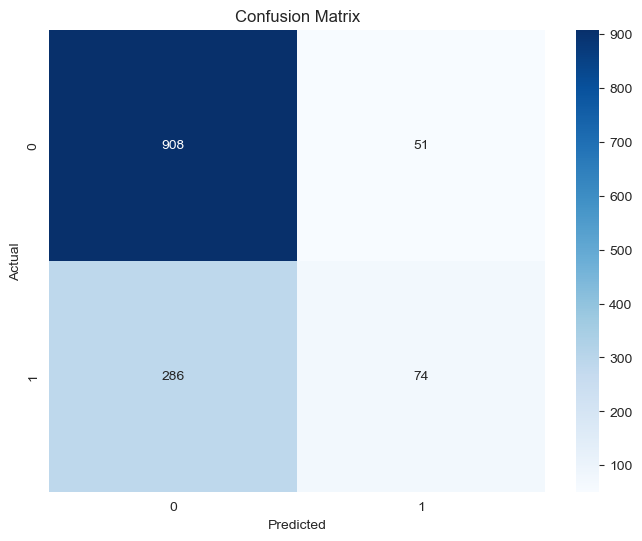

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
# 6.a Get predictions for confusion matrix and classification report
y_pred = (model.predict(pad_test) > 0.5).astype(int)
y_true = np.array([d['label'] for d in test_data])

# 6.b Generate confusion matrix and classification report
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_true, y_pred))

# 6.c Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

42/42 - 14s - loss: 0.5347 - accuracy: 0.7445 - 14s/epoch - 336ms/step
Test Loss: 0.5347, Test Acc: 0.7445


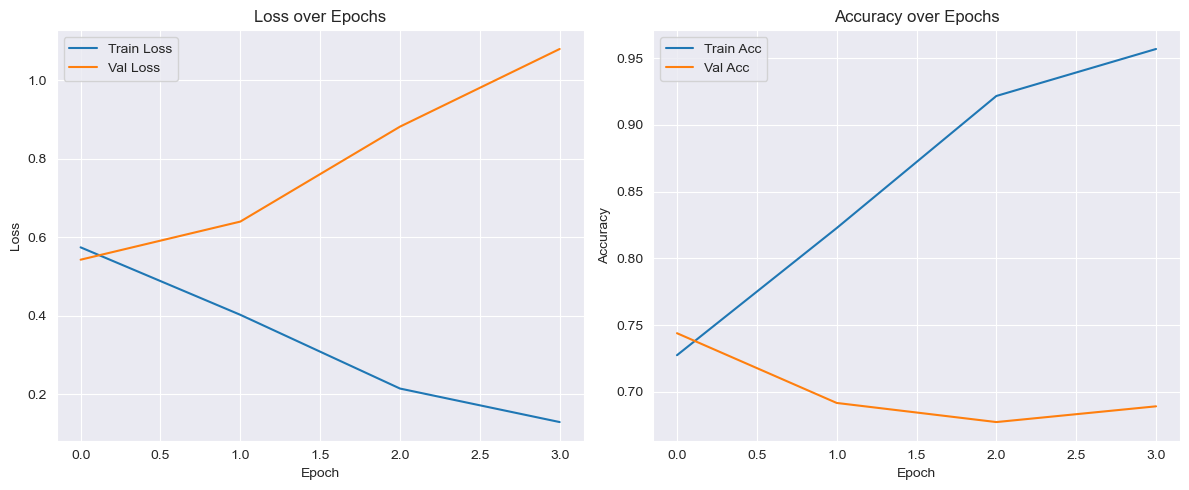

<Figure size 800x500 with 0 Axes>

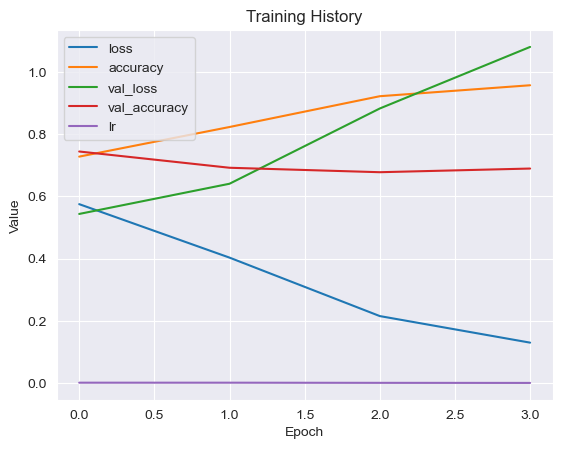

In [15]:
# 6. Evaluation on test set
loss, acc = model.evaluate(pad_test, np.array([d['label'] for d in test_data]), verbose=2)
print(f"Test Loss: {loss:.4f}, Test Acc: {acc:.4f}")

# 7. Plot training history
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# 7. Plot training history via pandas DataFrame
import pandas as pd
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend(loc='best')
plt.show()



42/42 - 16s - loss: 0.5347 - accuracy: 0.7445 - 16s/epoch - 386ms/step
Test Loss: 0.5347, Test Acc: 0.7445


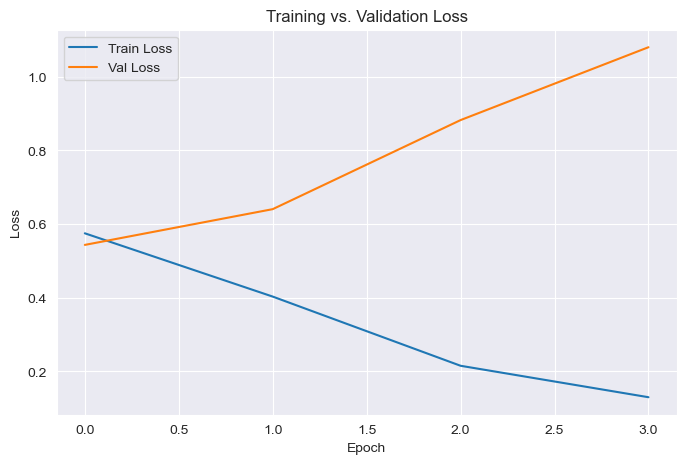

42/42 [==============================] - 14s 336ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.95      0.84       959
           1       0.59      0.21      0.31       360

    accuracy                           0.74      1319
   macro avg       0.68      0.58      0.57      1319
weighted avg       0.71      0.74      0.70      1319


Confusion Matrix:
[[908  51]
 [286  74]]


In [16]:
# 6. Evaluation on test set
loss, acc = model.evaluate(pad_test, np.array([d['label'] for d in test_data]), verbose=2)
print(f"Test Loss: {loss:.4f}, Test Acc: {acc:.4f}")

# 7. Plot training and validation loss in one graph
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

# 8. Summary statistics: confusion matrix и classification report
from sklearn.metrics import confusion_matrix, classification_report

y_true = np.array([d['label'] for d in test_data])
y_pred = (model.predict(pad_test) > 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_true, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))


In [17]:
history.history

{'loss': [0.5747291445732117,
  0.4028979539871216,
  0.21504780650138855,
  0.12966850399971008],
 'accuracy': [0.7274174094200134,
  0.822615385055542,
  0.921557605266571,
  0.9567537307739258],
 'val_loss': [0.5432326793670654,
  0.6402881145477295,
  0.8821319937705994,
  1.079945683479309],
 'val_accuracy': [0.7438921928405762,
  0.6916596293449402,
  0.6773378252983093,
  0.6891322731971741],
 'lr': [0.001, 0.001, 0.0005, 0.00025]}

In [18]:
#Test Loss: 0.5334, Test Acc: 0.7445 результат сейчас
#Test Loss: 0.5401, Test Acc: 0.7460 (2 попытка когда увеличил макс длину на 128 Сейчас вы обрезаете/дополняете последовательности до 100 токенов (max_len=100), а модель может “не видеть” важную информацию за пределами этого окна. Проанализируйте распределение длин текстов и, например, увеличьте max_len до 128
#Чтобы улучшить результаты модели LSTM на словацких данных я попробовал вместо того чтобы Embedding-слой начинал с случайных весов, я подгружаю эти вектора и кладу их в слой.
#Ради быстрой сходимости и лучшего качества
# модель сразу получает осмысленные эмбеддинги, она быстрее обучится и покажет более высокую точность, особенно на малом датасете.
# 3 попытка, условия теже)

#Test Loss: 0.5476, Test Acc: 0.7384(c контролем переобучения)
#Регуляризация сети: Внутри рекуррентного слоя LSTM были введены параметры dropout=0.2 и recurrent_dropout=0.2, что позволяет случайным образом «выключать» часть нейронов при каждом проходе и тем самым препятствовать избыточному запоминанию тренировочных образцов.После выхода из Bi-LSTM и перед первым полносвязанным слоем добавлен слой Dropout(0.3), а в самом Dense-слое применяется L2-регуляризация с коэффициентом λ=1e-4. Эти механизмы дополнительно штрафуют чрезмерно большие веса и способствуют более гладкому поведению функции потерь.

#Контроль процесса обучения: Реализован колбэк EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True), который автоматически прерывает обучение при отсутствии улучшения валидационной потери в течение двух подряд эпох и возвращает модель в состояние наивысшей достигнутой эффективности на валидационном наборе.Для динамической адаптации скорости обучения применяется ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-6), понижающий величину learning rate вдвое при остановке прогресса валидационной функции потерь, что позволяет точнее «осесть» в локальном минимуме.

#Оптимизация гиперпараметров: размер мини-пакета увеличен с 32 до 64 для более эффективного использования графического ускорителя и сглаживания градиентов.Общее число эпох сокращено до 30, поскольку за счёт EarlyStopping модель прекращает обучение в оптимальном моменте, предотвращая ненужное скольжение по переобученным состояниям.

#Добавление жёсткой регуляризации (Dropout, L2-шрафы и ранняя остановка) снижает склонность сети к переобучению, но при этом повышает смещение (bias) — модель «учится осторожнее», и на тренировочных данных она уже не так агрессивно подгоняется, из-за чего падают все метрики, в том числе и на валидации.Это обычный компромисс «смещение–дисперсия»: чтобы вернуть утраченную эффективность, нужно тонко настроить силу регуляризации и прочие гиперпараметры.
#Test Loss: 0.5468, Test Acc: 0.7293
#Classification Report:
#              precision    recall  f1-score   support
#
#           0       0.76      0.93      0.83       959
#           1       0.51      0.20      0.29       360

#    accuracy                           0.73      1319
#   macro avg       0.63      0.56      0.56      1319
#weighted avg       0.69      0.73      0.68      1319
